<a href="https://colab.research.google.com/github/Explicable11/JAUNDICE_PREDICTOR/blob/main/jaundice_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import cv2
from google.colab import drive
from google.colab.patches import cv2_imshow
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Concatenate, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tqdm import tqdm

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

# Define file paths
csv_path = '/content/drive/MyDrive/Jaundice2/chd_jaundice_published_2.csv'
image_dir = '/content/drive/MyDrive/Jaundice2/images'

# Load the CSV file
df = pd.read_csv(csv_path)

# Create a full path for each image
df['image_path'] = df['image_idx'].apply(lambda x: os.path.join(image_dir, x))

# --- MODIFIED FOR 2-CLASS CLASSIFICATION ---
def assign_class(bilirubin_level):
    return 0 if bilirubin_level <= 10 else 1  # 0 = Normal/Low, 1 = High

df['jaundice_class'] = df['blood(mg/dL)'].apply(assign_class)

# Display the first few rows and the binary class distribution
print("✅ Dataset Head with Binary Classes:")
print(df.head())

print("\n✅ Binary Class Distribution:")
print(df['jaundice_class'].value_counts())


✅ Dataset Head with Binary Classes:
   patient_id   image_idx gender  gestational_age  age(day)  weight  \
0           3  0003-1.jpg      F               40       5.2    3280   
1           3  0003-2.jpg      F               40       5.2    3280   
2           3  0003-3.jpg      F               40       5.2    3280   
3          35  0035-1.jpg      M               39       8.7    3760   
4          35  0035-2.jpg      M               39       8.7    3760   

   blood(mg/dL)  Treatment                                         image_path  \
0           3.9          0  /content/drive/MyDrive/Jaundice2/images/0003-1...   
1           3.9          0  /content/drive/MyDrive/Jaundice2/images/0003-2...   
2           3.9          0  /content/drive/MyDrive/Jaundice2/images/0003-3...   
3          12.2          0  /content/drive/MyDrive/Jaundice2/images/0035-1...   
4          12.2          0  /content/drive/MyDrive/Jaundice2/images/0035-2...   

   jaundice_class  
0               0  
1         

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# -------- Configuration --------
input_folder = "/content/drive/MyDrive/Jaundice2/images"
corrected_output_folder = "/content/drive/MyDrive/Jaundice2/sample_corrected_output_rgb"
roi_output_folder = "/content/drive/MyDrive/Jaundice2/sample_roi_output_rgb"
os.makedirs(corrected_output_folder, exist_ok=True)
os.makedirs(roi_output_folder, exist_ok=True)

# === CLAHE on V channel (HSV-based contrast enhancement, stays in RGB input/output)
def apply_rgb_color_correction(img_rgb):
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    v_clahe = clahe.apply(v)
    hsv_clahe = cv2.merge((h, s, v_clahe))
    corrected_rgb = cv2.cvtColor(hsv_clahe, cv2.COLOR_HSV2RGB)
    return corrected_rgb

# === Skin detection in RGB
def extract_skin_roi(image_rgb):
    # Define skin color range in RGB
    lower_skin = np.array([45, 34, 30], dtype=np.uint8)   # Lower bound for dark skin
    upper_skin = np.array([255, 220, 200], dtype=np.uint8)  # Upper bound for fair skin

    skin_mask = cv2.inRange(image_rgb, lower_skin, upper_skin)

    # Morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    coords = cv2.findNonZero(skin_mask)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        roi_size = 150
        cx, cy = x + w // 2, y + h // 2
        x1, y1 = max(0, cx - roi_size // 2), max(0, cy - roi_size // 2)
        x2, y2 = x1 + roi_size, y1 + roi_size
        return image_rgb[y1:y2, x1:x2]
    return None

# === Main processing loop ===
for filename in sorted(os.listdir(input_folder)):
    filepath = os.path.join(input_folder, filename)
    img_bgr = cv2.imread(filepath)
    if img_bgr is None:
        continue

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    corrected_rgb = apply_rgb_color_correction(img_rgb)
    roi_rgb = extract_skin_roi(corrected_rgb)

    if roi_rgb is not None:
        cv2.imwrite(os.path.join(corrected_output_folder, filename), cv2.cvtColor(corrected_rgb, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(roi_output_folder, filename), cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2BGR))


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd

# --- Configuration ---
roi_folder = "/content/drive/MyDrive/Jaundice2/sample_roi_output"
label_file = "/content/drive/MyDrive/Jaundice2/chd_jaundice_published_2.csv"   # Update if different
image_col = "image_idx"
target_col = "blood(mg/dL)"
save_x = "/content/drive/MyDrive/Jaundice2/X_rois.npy"
save_y = "/content/drive/MyDrive/Jaundice2/y_labels.npy"

# --- Load Labels ---
df = pd.read_csv(label_file)

X = []
y = []

for fname in os.listdir(roi_folder):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        matched = df[df[image_col] == fname]
        if matched.empty:

            continue
        img_path = os.path.join(roi_folder, fname)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Resize if needed
        img = img.astype(np.float32) / 255.0

        X.append(img)
        y.append(float(matched[target_col].values[0]))

X = np.array(X)
y = np.array(y)

np.save(save_x, X)
np.save(save_y, y)

print(f"✅ Saved {X.shape[0]} ROI samples as 'X_rois.npy'")
print(f"✅ Saved corresponding labels as 'y_labels.npy'")


✅ Saved 2235 ROI samples as 'X_rois.npy'
✅ Saved corresponding labels as 'y_labels.npy'


📊 Original counts: ≤10 = 876, >10 = 1359


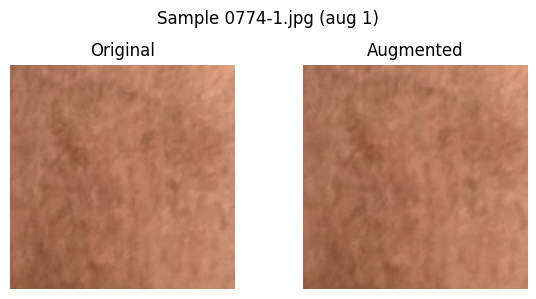

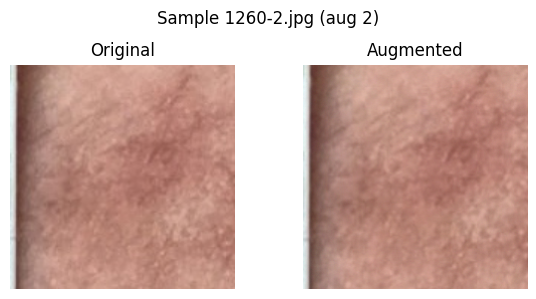

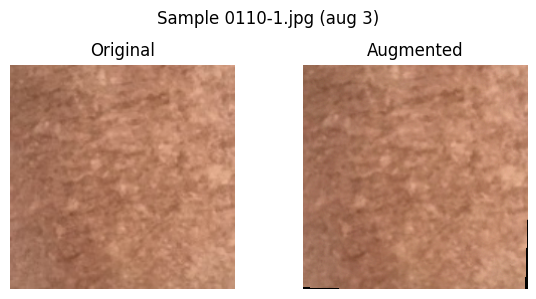

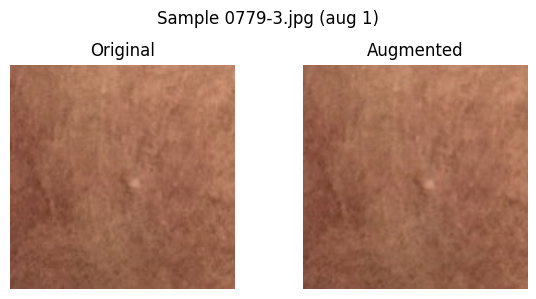

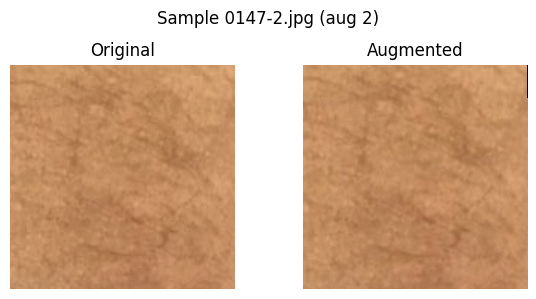

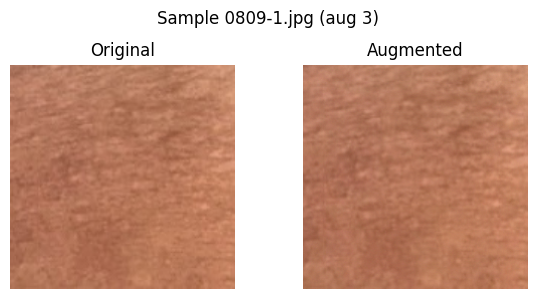

✅ Saved 7000 samples to: /content/drive/MyDrive/Jaundice2/X_aug_knn.npy
✅ Labels distribution: [3500 3500]


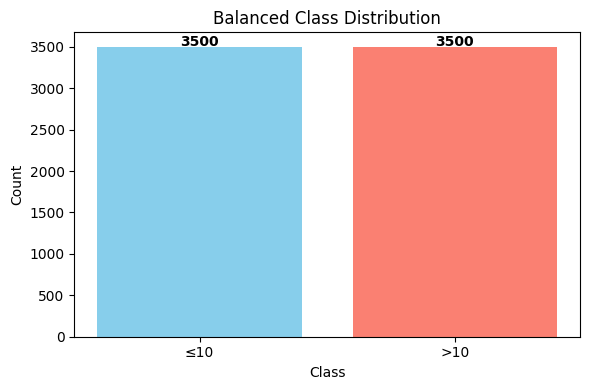

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from collections import defaultdict

# --- Configuration ---
roi_folder = "/content/drive/MyDrive/Jaundice2/sample_roi_output"
label_file = "/content/drive/MyDrive/Jaundice2/chd_jaundice_published_2.csv"
image_col = "image_idx"
target_col = "blood(mg/dL)"
threshold = 10.0  # Binary cutoff: ≤10 → 0, >10 → 1
save_x = "/content/drive/MyDrive/Jaundice2/X_aug_knn.npy"
save_y = "/content/drive/MyDrive/Jaundice2/y_aug_knn.npy"
target_count = 3500
show_examples = True

# --- Load labels ---
df = pd.read_csv(label_file)

# --- Gentle Augmentation (paper-safe) ---
class GentleAugment:
    def __init__(self):
        self.base_size = 232  # Slightly larger than 224x224
        self.transform = transforms.Compose([
            transforms.Resize(self.base_size),
            transforms.RandomRotation(degrees=3, fill=0),
            transforms.RandomCrop(224, pad_if_needed=True),
        ])
        self.to_tensor = transforms.ToTensor()

    def __call__(self, img):
        img = self.transform(img)
        img = self.to_tensor(img)
        noise = torch.randn_like(img) * 0.005  # Gentle noise
        return torch.clamp(img + noise, 0, 1)

augment = GentleAugment()

def show_before_after(original, augmented, idx):
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(augmented)
    plt.title("Augmented")
    plt.axis('off')
    plt.suptitle(f"Sample {idx}")
    plt.tight_layout()
    plt.show()

# --- Step 1: Organize images by class ---
class_data = defaultdict(list)

for fname in os.listdir(roi_folder):
    if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    row = df[df[image_col] == fname]
    if row.empty:
        continue

    try:
        value = float(row[target_col].values[0])
    except:
        print(f"⚠ Invalid label for {fname}")
        continue

    label = 0 if value <= threshold else 1

    img_path = os.path.join(roi_folder, fname)
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠ Cannot read image: {fname}")
        continue

    img = cv2.resize(img, (224, 224))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    class_data[label].append((img_rgb, fname))

# --- Step 2: Balance both classes to target_count ---
X, y = [], []

print(f"📊 Original counts: ≤10 = {len(class_data[0])}, >10 = {len(class_data[1])}")

for label in [0, 1]:
    original = class_data[label]
    cur_count = len(original)

    if cur_count >= target_count:
        selected = random.sample(original, target_count)
        for img, _ in selected:
            X.append(img)
            y.append(label)
    else:
        for img, _ in original:
            X.append(img)
            y.append(label)

        # Augment to reach target_count
        needed = target_count - cur_count
        to_aug = random.choices(original, k=needed)
        for idx, (img, fname) in enumerate(to_aug):
            pil = Image.fromarray((img * 255).astype(np.uint8))
            aug_tensor = augment(pil)
            aug_img = aug_tensor.permute(1, 2, 0).numpy()
            X.append(aug_img)
            y.append(label)

            if show_examples and idx < 3:
                show_before_after(img, aug_img, f"{fname} (aug {idx+1})")

# --- Step 3: Save as NumPy arrays ---
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.uint8)

np.save(save_x, X)
np.save(save_y, y)

print(f"✅ Saved {X.shape[0]} samples to: {save_x}")
print(f"✅ Labels distribution: {np.bincount(y)}")

# --- Step 4: Plot class balance ---
plt.figure(figsize=(6, 4))
plt.bar(['≤10', '>10'], np.bincount(y), color=['skyblue', 'salmon'])
plt.title("Balanced Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
for i, v in enumerate(np.bincount(y)):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from collections import Counter

# === Load the augmented dataset generated for KNN ===
X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn.npy')
y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')

print(f"🔍 Total samples in X: {X.shape}")
print(f"🔍 Total labels in y: {y.shape}")

# === Verify label range and count classes ===
unique_vals = np.unique(y)
if set(unique_vals) == {0, 1}:
    class_counts = Counter(y.astype(int))  # Just in case labels are uint8
else:
    raise ValueError(f"❌ Unexpected labels found in y: {unique_vals}. Expected only 0 and 1.")

print("\n📊 Final Class Distribution (Binary: ≤10 vs >10):")
print(f"  Class 0 (≤10): {class_counts[0]} samples")
print(f"  Class 1 (>10): {class_counts[1]} samples")


🔍 Total samples in X: (7000, 224, 224, 3)
🔍 Total labels in y: (7000,)

📊 Final Class Distribution (Binary: ≤10 vs >10):
  Class 0 (≤10): 3500 samples
  Class 1 (>10): 3500 samples


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

# === Step 1: Load augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')

except FileNotFoundError:
    raise FileNotFoundError("❌ Augmented files not found. Please generate X_aug_knn.npy and y_aug_knn.npy first.")

print(f"📦 Loaded X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 images into 1D feature vectors ===
X = X.reshape((X.shape[0], -1))  # shape: (6000, 150528)
print(f"📐 Flattened X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))  # keep 100 components max
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train KNN ===
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)

print("🧠 Training KNN classifier...")
knn.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = knn.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + KNN: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))


📦 Loaded X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training KNN classifier...
✅ Training complete.

🎯 Accuracy after PCA + KNN: 0.9414
              precision    recall  f1-score   support

         ≤10       0.92      0.96      0.94       700
         >10       0.96      0.92      0.94       700

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400



🎯 Verified Accuracy: 0.9414


<Figure size 600x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


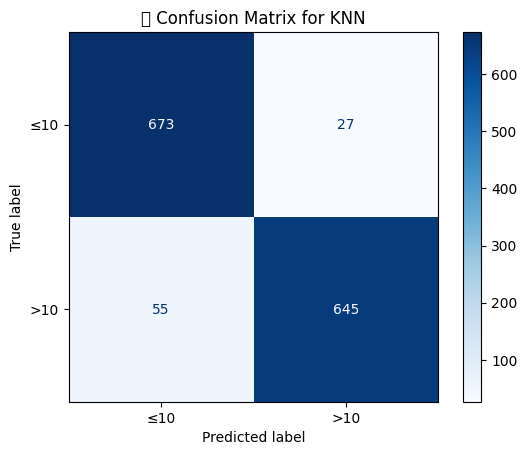

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# === Predict again to ensure sync ===
y_pred = knn.predict(X_test_pca)

# === Print actual accuracy ===
acc = accuracy_score(y_test, y_pred)
print(f"🎯 Verified Accuracy: {acc:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["≤10", ">10"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("✅ Confusion Matrix for KNN")
plt.grid(False)
plt.show()


RANDOM FOREST

📦 Loaded X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training Random Forest classifier...
✅ Training complete.

🎯 Accuracy after PCA + Random Forest: 0.9193
              precision    recall  f1-score   support

         ≤10       0.91      0.93      0.92       700
         >10       0.93      0.91      0.92       700

    accuracy                           0.92      1400
   macro avg       0.92      0.92      0.92      1400
weighted avg       0.92      0.92      0.92      1400


🧮 Confusion Matrix:
[[652  48]
 [ 65 635]]


/tmp/ipython-input-13-1264653410.py:92: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


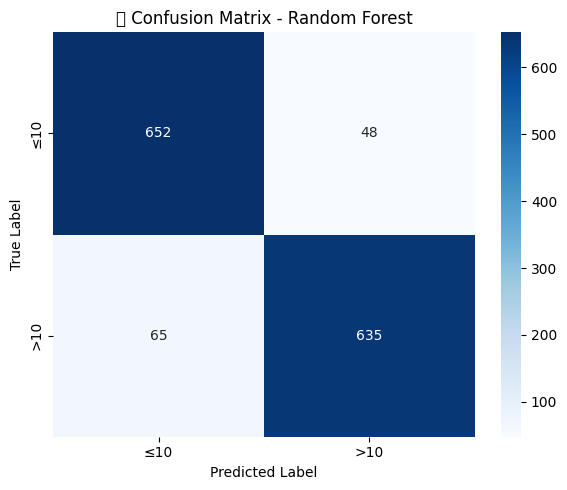

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')

except FileNotFoundError:
    raise FileNotFoundError("❌ Augmented files not found. Please generate X_aug_knn.npy and y_aug_knn.npy first.")

print(f"📦 Loaded X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 images into 1D feature vectors ===
X = X.reshape((X.shape[0], -1))  # shape: (6000, 150528)
print(f"📐 Flattened X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train Random Forest ===
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

print("🧠 Training Random Forest classifier...")
rf.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = rf.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + Random Forest: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


XGBOOST


📦 Loaded X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training XGBoost classifier...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:13:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Training complete.

🎯 Accuracy after PCA + XGBoost: 0.9229
              precision    recall  f1-score   support

         ≤10       0.91      0.94      0.92       700
         >10       0.93      0.91      0.92       700

    accuracy                           0.92      1400
   macro avg       0.92      0.92      0.92      1400
weighted avg       0.92      0.92      0.92      1400


🧮 Confusion Matrix:
[[655  45]
 [ 63 637]]


/tmp/ipython-input-14-880724870.py:95: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


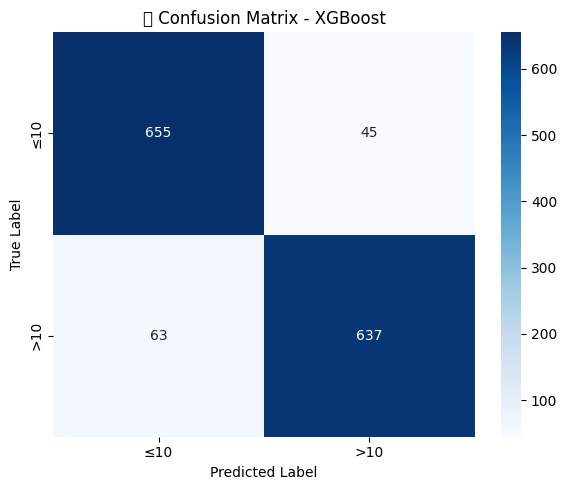

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')

except FileNotFoundError:
    raise FileNotFoundError("❌ Augmented files not found. Please generate X_aug_knn.npy and y_aug_knn.npy first.")

print(f"📦 Loaded X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 images into 1D feature vectors ===
X = X.reshape((X.shape[0], -1))  # shape: (6000, 150528)
print(f"📐 Flattened X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))  # keep 100 components max
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train XGBoost ===
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

print("🧠 Training XGBoost classifier...")
xgb.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = xgb.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + XGBoost: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


SVM

📦 Loaded X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training SVM classifier...
✅ Training complete.

🎯 Accuracy after PCA + SVM: 0.8436
              precision    recall  f1-score   support

         ≤10       0.85      0.84      0.84       700
         >10       0.84      0.85      0.84       700

    accuracy                           0.84      1400
   macro avg       0.84      0.84      0.84      1400
weighted avg       0.84      0.84      0.84      1400


🧮 Confusion Matrix:
[[585 115]
 [104 596]]


/tmp/ipython-input-15-473973538.py:93: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


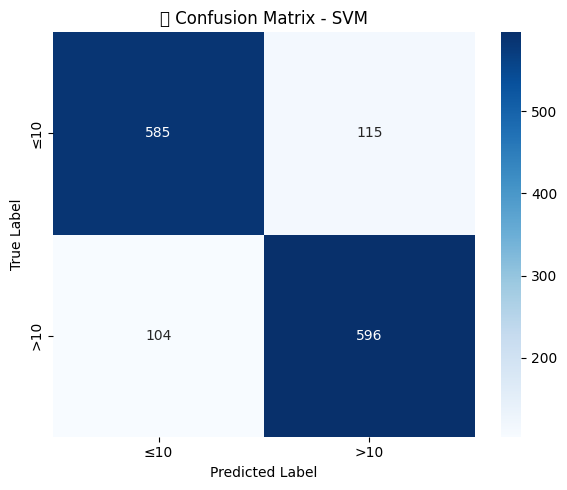

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')

except FileNotFoundError:
    raise FileNotFoundError("❌ Augmented files not found. Please generate X_aug_knn.npy and y_aug_knn.npy first.")

print(f"📦 Loaded X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 images into 1D feature vectors ===
X = X.reshape((X.shape[0], -1))  # shape: (6000, 150528)
print(f"📐 Flattened X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))  # keep 100 components max
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train SVM ===
svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

print("🧠 Training SVM classifier...")
svm.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = svm.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + SVM: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


**HSV**

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# -------- Configuration --------
input_folder = "/content/drive/MyDrive/Jaundice2/images"
corrected_output_folder = "/content/drive/MyDrive/Jaundice2/sample_corrected_output_hsv"
roi_output_folder = "/content/drive/MyDrive/Jaundice2/sample_roi_output_hsv"
os.makedirs(corrected_output_folder, exist_ok=True)
os.makedirs(roi_output_folder, exist_ok=True)

# === CLAHE on V channel (HSV-based contrast enhancement, stays in RGB input/output)
def apply_hsv_color_correction(img_rgb):
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    v_clahe = clahe.apply(v)
    hsv_clahe = cv2.merge((h, s, v_clahe))
    corrected_rgb = cv2.cvtColor(hsv_clahe, cv2.COLOR_HSV2RGB)
    return corrected_rgb

# === Skin detection in HSV
def extract_skin_roi_hsv(image_rgb):
    image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    # Define skin color range in HSV (tuned for general skin)
    lower_skin = np.array([0, 40, 60], dtype=np.uint8)
    upper_skin = np.array([25, 255, 255], dtype=np.uint8)

    skin_mask = cv2.inRange(image_hsv, lower_skin, upper_skin)

    # Morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    coords = cv2.findNonZero(skin_mask)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        roi_size = 150
        cx, cy = x + w // 2, y + h // 2
        x1, y1 = max(0, cx - roi_size // 2), max(0, cy - roi_size // 2)
        x2, y2 = x1 + roi_size, y1 + roi_size
        return image_rgb[y1:y2, x1:x2]
    return None

# === Main processing loop ===
for filename in sorted(os.listdir(input_folder)):
    filepath = os.path.join(input_folder, filename)
    img_bgr = cv2.imread(filepath)
    if img_bgr is None:
        continue

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    corrected_rgb = apply_hsv_color_correction(img_rgb)
    roi_rgb = extract_skin_roi_hsv(corrected_rgb)

    if roi_rgb is not None:
        cv2.imwrite(os.path.join(corrected_output_folder, filename), cv2.cvtColor(corrected_rgb, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(roi_output_folder, filename), cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2BGR))


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd

# --- Configuration ---
roi_folder = "/content/drive/MyDrive/Jaundice2/sample_roi_output"
label_file = "/content/drive/MyDrive/Jaundice2/chd_jaundice_published_2.csv"
image_col = "image_idx"
target_col = "blood(mg/dL)"
save_x = "/content/drive/MyDrive/Jaundice2/X_rois_hsv.npy"
save_y = "/content/drive/MyDrive/Jaundice2/y_labels.npy"

# --- Load Labels ---
df = pd.read_csv(label_file)

X = []
y = []

for fname in os.listdir(roi_folder):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        matched = df[df[image_col] == fname]
        if matched.empty:
            continue

        img_path = os.path.join(roi_folder, fname)
        img_bgr = cv2.imread(img_path)
        img_bgr = cv2.resize(img_bgr, (224, 224))  # Resize to standard shape

        # === Convert to HSV and normalize ===
        img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
        img_hsv[..., 0] /= 179.0   # Normalize H: 0–179 → 0–1
        img_hsv[..., 1] /= 255.0   # Normalize S: 0–255 → 0–1
        img_hsv[..., 2] /= 255.0   # Normalize V: 0–255 → 0–1

        X.append(img_hsv)
        y.append(float(matched[target_col].values[0]))

X = np.array(X)
y = np.array(y)

np.save(save_x, X)
np.save(save_y, y)

print(f"✅ Saved {X.shape[0]} HSV ROI samples as '{os.path.basename(save_x)}'")
print(f"✅ Saved corresponding labels as '{os.path.basename(save_y)}'")


✅ Saved 2235 HSV ROI samples as 'X_rois_hsv.npy'
✅ Saved corresponding labels as 'y_labels.npy'


📊 Original counts: ≤10 = 876, >10 = 1359


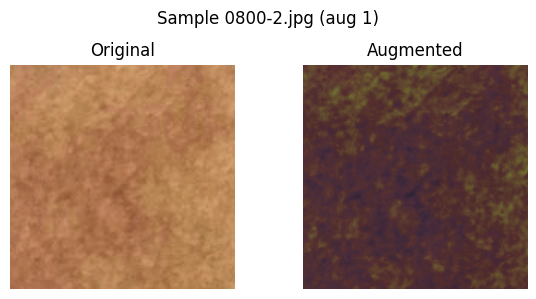

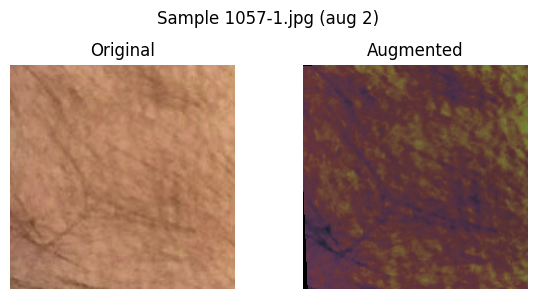

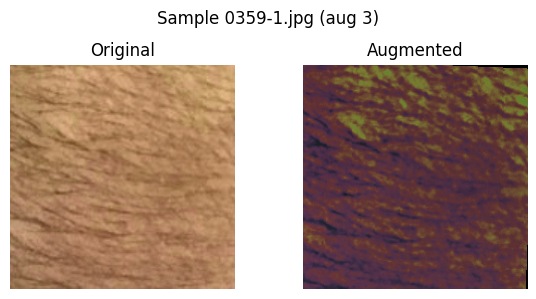

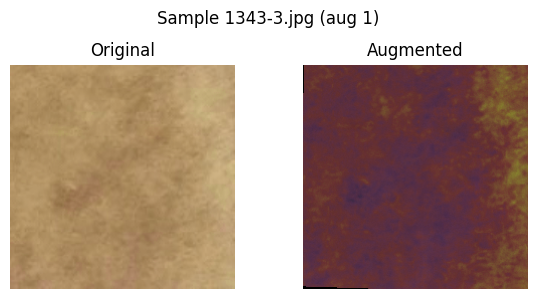

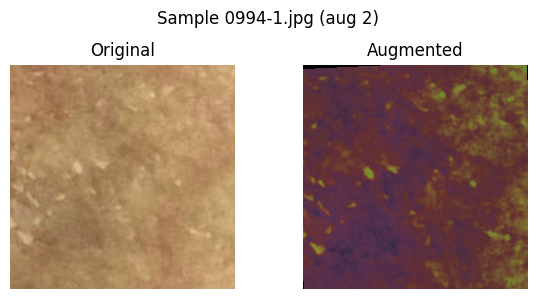

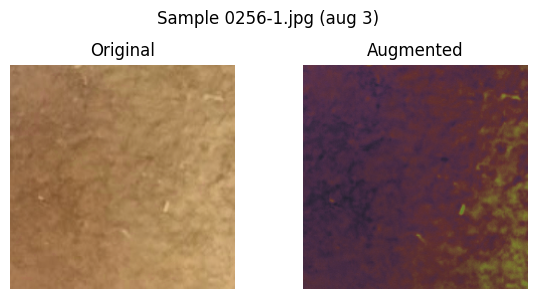

✅ Saved 7000 HSV samples to: /content/drive/MyDrive/Jaundice2/X_aug_knn_hsv.npy
✅ Labels distribution: [3500 3500]


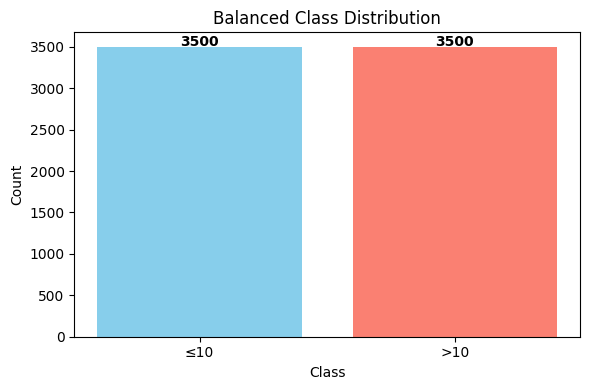

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from collections import defaultdict

# --- Configuration ---
roi_folder = "/content/drive/MyDrive/Jaundice2/sample_roi_output"
label_file = "/content/drive/MyDrive/Jaundice2/chd_jaundice_published_2.csv"
image_col = "image_idx"
target_col = "blood(mg/dL)"
threshold = 10.0  # Binary cutoff
save_x = "/content/drive/MyDrive/Jaundice2/X_aug_knn_hsv.npy"
save_y = "/content/drive/MyDrive/Jaundice2/y_aug_knn.npy"
target_count = 3500
show_examples = True

# --- Load labels ---
df = pd.read_csv(label_file)

# --- Gentle HSV-safe Augmentation ---
class GentleAugment:
    def __init__(self):
        self.base_size = 232
        self.transform = transforms.Compose([
            transforms.Resize(self.base_size),
            transforms.RandomRotation(degrees=3, fill=0),
            transforms.RandomCrop(224, pad_if_needed=True),
        ])
        self.to_tensor = transforms.ToTensor()

    def __call__(self, img):
        img = self.transform(img)
        img = self.to_tensor(img)
        noise = torch.randn_like(img) * 0.005
        return torch.clamp(img + noise, 0, 1)

augment = GentleAugment()

def show_before_after(original_hsv, augmented_tensor, idx):
    orig_bgr = cv2.cvtColor((original_hsv * 255).astype(np.uint8), cv2.COLOR_HSV2RGB)
    aug_np = augmented_tensor.permute(1, 2, 0).numpy()
    aug_bgr = cv2.cvtColor((aug_np * 255).astype(np.uint8), cv2.COLOR_HSV2RGB)

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_bgr)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(aug_bgr)
    plt.title("Augmented")
    plt.axis('off')
    plt.suptitle(f"Sample {idx}")
    plt.tight_layout()
    plt.show()

# --- Step 1: Organize images by class ---
class_data = defaultdict(list)

for fname in os.listdir(roi_folder):
    if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    row = df[df[image_col] == fname]
    if row.empty:
        continue

    try:
        value = float(row[target_col].values[0])
    except:
        print(f"⚠ Invalid label for {fname}")
        continue

    label = 0 if value <= threshold else 1

    img_path = os.path.join(roi_folder, fname)
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠ Cannot read image: {fname}")
        continue

    img = cv2.resize(img, (224, 224))
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    img_hsv[..., 0] /= 179.0
    img_hsv[..., 1] /= 255.0
    img_hsv[..., 2] /= 255.0

    class_data[label].append((img_hsv, fname))

# --- Step 2: Balance both classes to target_count ---
X, y = [], []

print(f"📊 Original counts: ≤10 = {len(class_data[0])}, >10 = {len(class_data[1])}")

for label in [0, 1]:
    original = class_data[label]
    cur_count = len(original)

    if cur_count >= target_count:
        selected = random.sample(original, target_count)
        for img, _ in selected:
            X.append(img)
            y.append(label)
    else:
        for img, _ in original:
            X.append(img)
            y.append(label)

        # Augment to reach target_count
        needed = target_count - cur_count
        to_aug = random.choices(original, k=needed)
        for idx, (img, fname) in enumerate(to_aug):
            pil = Image.fromarray((img * 255).astype(np.uint8), mode='HSV').convert("RGB")
            aug_tensor = augment(pil)
            aug_np = aug_tensor.permute(1, 2, 0).numpy()

            # Convert augmented RGB back to HSV and normalize
            aug_hsv = cv2.cvtColor((aug_np * 255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
            aug_hsv[..., 0] /= 179.0
            aug_hsv[..., 1] /= 255.0
            aug_hsv[..., 2] /= 255.0

            X.append(aug_hsv)
            y.append(label)

            if show_examples and idx < 3:
                show_before_after(img, aug_tensor, f"{fname} (aug {idx+1})")

# --- Step 3: Save arrays ---
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.uint8)

np.save(save_x, X)
np.save(save_y, y)

print(f"✅ Saved {X.shape[0]} HSV samples to: {save_x}")
print(f"✅ Labels distribution: {np.bincount(y)}")

# --- Step 4: Plot class balance ---
plt.figure(figsize=(6, 4))
plt.bar(['≤10', '>10'], np.bincount(y), color=['skyblue', 'salmon'])
plt.title("Balanced Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
for i, v in enumerate(np.bincount(y)):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from collections import Counter

# === Load the HSV-augmented dataset for KNN ===
X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_hsv.npy')
y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')

print(f"🔍 Total samples in X (HSV): {X.shape}")
print(f"🔍 Total labels in y: {y.shape}")

# === Verify label range and count classes ===
unique_vals = np.unique(y)
if set(unique_vals) == {0, 1}:
    class_counts = Counter(y.astype(int))
else:
    raise ValueError(f"❌ Unexpected labels found in y: {unique_vals}. Expected only 0 and 1.")

print("\n📊 Final Class Distribution (Binary: ≤10 vs >10):")
print(f"  Class 0 (≤10): {class_counts[0]} samples")
print(f"  Class 1 (>10): {class_counts[1]} samples")


🔍 Total samples in X (HSV): (7000, 224, 224, 3)
🔍 Total labels in y: (7000,)

📊 Final Class Distribution (Binary: ≤10 vs >10):
  Class 0 (≤10): 3500 samples
  Class 1 (>10): 3500 samples


KNN

📦 Loaded HSV X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened HSV X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training KNN classifier...
✅ Training complete.

🎯 Accuracy after PCA + KNN on HSV: 0.9443
              precision    recall  f1-score   support

         ≤10       0.94      0.95      0.94       700
         >10       0.95      0.93      0.94       700

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400


🧮 Confusion Matrix:
[[668  32]
 [ 46 654]]


/tmp/ipython-input-2-3128876729.py:87: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


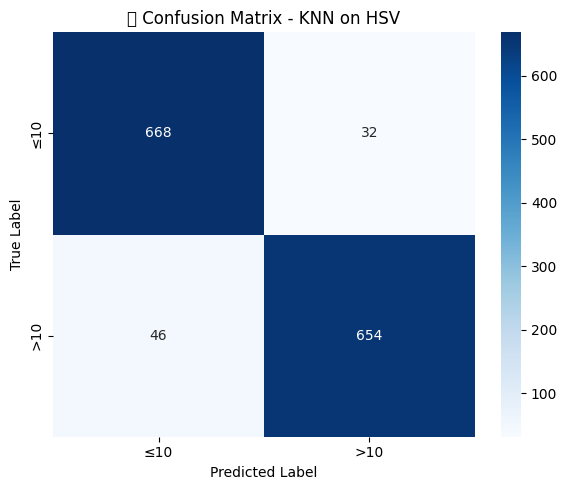

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load HSV-augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_hsv.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')

except FileNotFoundError:
    raise FileNotFoundError("❌ HSV-augmented files not found. Please generate X_aug_knn_hsv.npy and y_aug_knn.npy first.")

print(f"📦 Loaded HSV X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 HSV images into 1D vectors ===
X = X.reshape((X.shape[0], -1))
print(f"📐 Flattened HSV X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train KNN classifier ===
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)

print("🧠 Training KNN classifier...")
knn.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = knn.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + KNN on HSV: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - KNN on HSV")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


RANDOM FOREST

📦 Loaded HSV X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened HSV X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training Random Forest classifier on HSV...
✅ Training complete.

🎯 Accuracy after PCA + Random Forest on HSV: 0.9229
              precision    recall  f1-score   support

         ≤10       0.91      0.94      0.92       700
         >10       0.93      0.91      0.92       700

    accuracy                           0.92      1400
   macro avg       0.92      0.92      0.92      1400
weighted avg       0.92      0.92      0.92      1400


🧮 Confusion Matrix:
[[655  45]
 [ 63 637]]


/tmp/ipython-input-3-3394751631.py:92: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


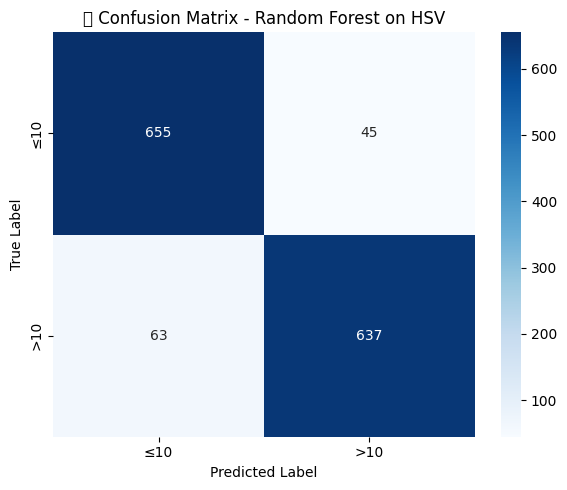

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load HSV-augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_hsv.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')

except FileNotFoundError:
    raise FileNotFoundError("❌ HSV-augmented files not found. Please generate X_aug_knn_hsv.npy and y_aug_knn.npy first.")

print(f"📦 Loaded HSV X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 HSV images into 1D vectors ===
X = X.reshape((X.shape[0], -1))
print(f"📐 Flattened HSV X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train Random Forest classifier ===
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

print("🧠 Training Random Forest classifier on HSV...")
rf.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = rf.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + Random Forest on HSV: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - Random Forest on HSV")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


XGBOOST

📦 Loaded HSV X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened HSV X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training XGBoost classifier on HSV...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:09:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Training complete.

🎯 Accuracy after PCA + XGBoost on HSV: 0.9100
              precision    recall  f1-score   support

         ≤10       0.91      0.91      0.91       700
         >10       0.91      0.91      0.91       700

    accuracy                           0.91      1400
   macro avg       0.91      0.91      0.91      1400
weighted avg       0.91      0.91      0.91      1400


🧮 Confusion Matrix:
[[635  65]
 [ 61 639]]


/tmp/ipython-input-4-292910357.py:94: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


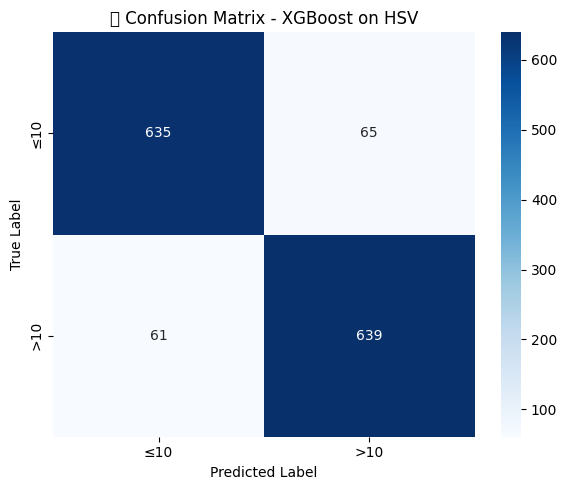

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier  # ✅ Using XGBoost instead of RandomForest

# === Step 1: Load HSV-augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_hsv.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')
except FileNotFoundError:
    raise FileNotFoundError("❌ HSV-augmented files not found. Please generate X_aug_knn_hsv.npy and y_aug_knn.npy first.")

print(f"📦 Loaded HSV X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 HSV images into 1D vectors ===
X = X.reshape((X.shape[0], -1))
print(f"📐 Flattened HSV X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train XGBoost classifier ===
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

print("🧠 Training XGBoost classifier on HSV...")
xgb.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = xgb.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + XGBoost on HSV: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - XGBoost on HSV")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


SVM

📦 Loaded HSV X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened HSV X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training SVM classifier on HSV...
✅ Training complete.

🎯 Accuracy after PCA + SVM on HSV: 0.8193
              precision    recall  f1-score   support

         ≤10       0.83      0.81      0.82       700
         >10       0.81      0.83      0.82       700

    accuracy                           0.82      1400
   macro avg       0.82      0.82      0.82      1400
weighted avg       0.82      0.82      0.82      1400


🧮 Confusion Matrix:
[[566 134]
 [119 581]]


/tmp/ipython-input-5-1834850271.py:92: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


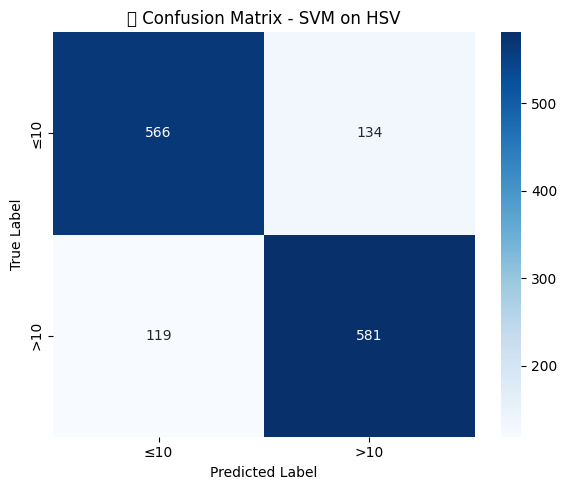

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC  # ✅ Importing SVM
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load HSV-augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_hsv.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')
except FileNotFoundError:
    raise FileNotFoundError("❌ HSV-augmented files not found. Please generate X_aug_knn_hsv.npy and y_aug_knn.npy first.")

print(f"📦 Loaded HSV X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 HSV images into 1D vectors ===
X = X.reshape((X.shape[0], -1))
print(f"📐 Flattened HSV X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train SVM classifier ===
svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

print("🧠 Training SVM classifier on HSV...")
svm.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = svm.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + SVM on HSV: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - SVM on HSV")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


***Ycbcr***

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# -------- Configuration --------
input_folder = "/content/drive/MyDrive/Jaundice2/images"
corrected_output_folder = "/content/drive/MyDrive/Jaundice2/sample_corrected_output_ycbcr"
roi_output_folder = "/content/drive/MyDrive/Jaundice2/sample_roi_output_ycbcr"
os.makedirs(corrected_output_folder, exist_ok=True)
os.makedirs(roi_output_folder, exist_ok=True)

# === CLAHE on Y channel (YCbCr-based contrast enhancement)
def apply_ycbcr_color_correction(img_rgb):
    ycbcr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(ycbcr)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    y_clahe = clahe.apply(y)

    ycbcr_clahe = cv2.merge((y_clahe, cr, cb))
    corrected_rgb = cv2.cvtColor(ycbcr_clahe, cv2.COLOR_YCrCb2RGB)
    return corrected_rgb

# === Skin detection in YCbCr
def extract_skin_roi_ycbcr(image_rgb):
    image_ycbcr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YCrCb)

    # Define skin color range in YCbCr
    lower_skin = np.array([0, 135, 85], dtype=np.uint8)
    upper_skin = np.array([255, 180, 135], dtype=np.uint8)

    skin_mask = cv2.inRange(image_ycbcr, lower_skin, upper_skin)

    # Morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    coords = cv2.findNonZero(skin_mask)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        roi_size = 150
        cx, cy = x + w // 2, y + h // 2
        x1, y1 = max(0, cx - roi_size // 2), max(0, cy - roi_size // 2)
        x2, y2 = x1 + roi_size, y1 + roi_size
        return image_rgb[y1:y2, x1:x2]
    return None

# === Main processing loop ===
for filename in sorted(os.listdir(input_folder)):
    filepath = os.path.join(input_folder, filename)
    img_bgr = cv2.imread(filepath)
    if img_bgr is None:
        continue

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    corrected_rgb = apply_ycbcr_color_correction(img_rgb)
    roi_rgb = extract_skin_roi_ycbcr(corrected_rgb)

    if roi_rgb is not None:
        cv2.imwrite(os.path.join(corrected_output_folder, filename), cv2.cvtColor(corrected_rgb, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(roi_output_folder, filename), cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2BGR))


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd

# --- Configuration ---
roi_folder = "/content/drive/MyDrive/Jaundice2/sample_roi_output"
label_file = "/content/drive/MyDrive/Jaundice2/chd_jaundice_published_2.csv"
image_col = "image_idx"
target_col = "blood(mg/dL)"
save_x = "/content/drive/MyDrive/Jaundice2/X_rois_ycbcr.npy"
save_y = "/content/drive/MyDrive/Jaundice2/y_labels.npy"

# --- Load Labels ---
df = pd.read_csv(label_file)

X = []
y = []

for fname in os.listdir(roi_folder):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        matched = df[df[image_col] == fname]
        if matched.empty:
            continue

        img_path = os.path.join(roi_folder, fname)
        img_bgr = cv2.imread(img_path)
        img_bgr = cv2.resize(img_bgr, (224, 224))  # Resize to standard shape

        # === Convert to YCbCr and normalize ===
        img_ycbcr = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb).astype(np.float32)
        img_ycbcr[..., 0] /= 255.0  # Normalize Y
        img_ycbcr[..., 1] /= 255.0  # Normalize Cr
        img_ycbcr[..., 2] /= 255.0  # Normalize Cb

        X.append(img_ycbcr)
        y.append(float(matched[target_col].values[0]))

X = np.array(X, dtype=np.float32)
y = np.array(y)

np.save(save_x, X)
np.save(save_y, y)

print(f"✅ Saved {X.shape[0]} YCbCr ROI samples as '{os.path.basename(save_x)}'")
print(f"✅ Saved corresponding labels as '{os.path.basename(save_y)}'")


✅ Saved 2235 YCbCr ROI samples as 'X_rois_ycbcr.npy'
✅ Saved corresponding labels as 'y_labels.npy'


📊 Original counts: ≤10 = 876, >10 = 1359


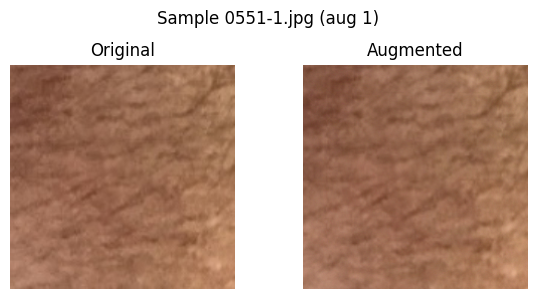

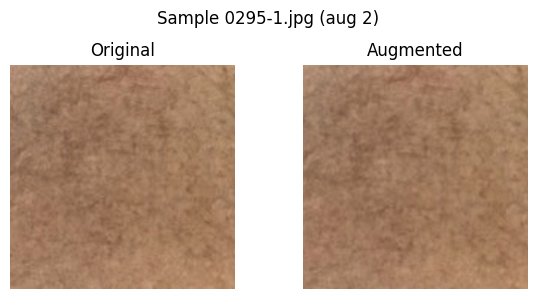

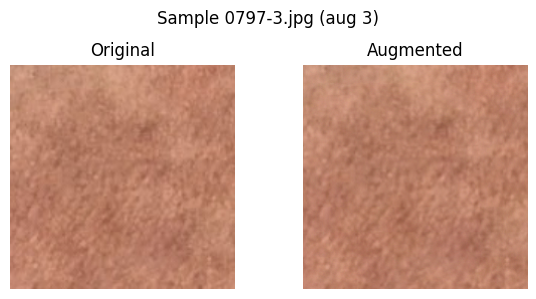

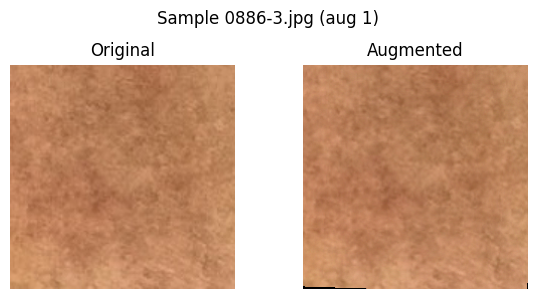

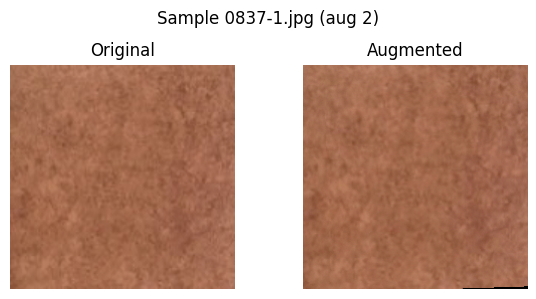

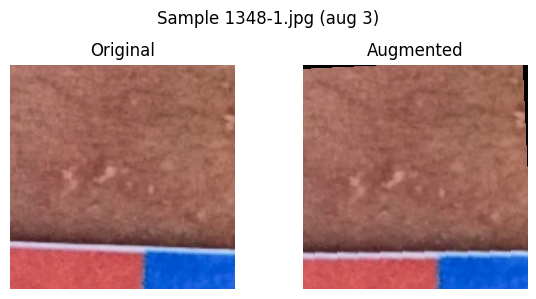

✅ Saved 7000 YCbCr samples to: /content/drive/MyDrive/Jaundice2/X_aug_knn_ycbcr.npy
✅ Labels distribution: [3500 3500]


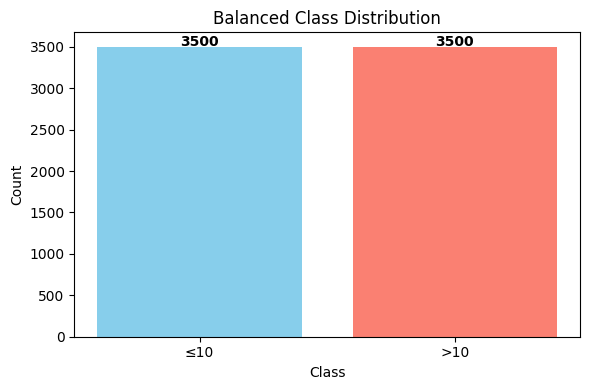

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from collections import defaultdict

# --- Configuration ---
roi_folder = "/content/drive/MyDrive/Jaundice2/sample_roi_output"
label_file = "/content/drive/MyDrive/Jaundice2/chd_jaundice_published_2.csv"
image_col = "image_idx"
target_col = "blood(mg/dL)"
threshold = 10.0
save_x = "/content/drive/MyDrive/Jaundice2/X_aug_knn_ycbcr.npy"
save_y = "/content/drive/MyDrive/Jaundice2/y_aug_knn.npy"
target_count = 3500
show_examples = True

# --- Load labels ---
df = pd.read_csv(label_file)

# --- Gentle RGB-based Augmentation ---
class GentleAugment:
    def __init__(self):
        self.base_size = 232
        self.transform = transforms.Compose([
            transforms.Resize(self.base_size),
            transforms.RandomRotation(degrees=3, fill=0),
            transforms.RandomCrop(224, pad_if_needed=True),
        ])
        self.to_tensor = transforms.ToTensor()

    def __call__(self, img):
        img = self.transform(img)
        img = self.to_tensor(img)
        noise = torch.randn_like(img) * 0.005
        return torch.clamp(img + noise, 0, 1)

augment = GentleAugment()

# --- Visualizer for before/after (YCbCr -> RGB) ---
def show_before_after(original_ycbcr, augmented_tensor, idx):
    orig_bgr = cv2.cvtColor((original_ycbcr * 255).astype(np.uint8), cv2.COLOR_YCrCb2RGB)
    aug_np = augmented_tensor.permute(1, 2, 0).numpy()
    aug_bgr = aug_np  # Already in RGB format

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_bgr)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(aug_bgr)
    plt.title("Augmented")
    plt.axis('off')
    plt.suptitle(f"Sample {idx}")
    plt.tight_layout()
    plt.show()

# --- Step 1: Organize by class ---
class_data = defaultdict(list)

for fname in os.listdir(roi_folder):
    if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    row = df[df[image_col] == fname]
    if row.empty:
        continue

    try:
        value = float(row[target_col].values[0])
    except:
        print(f"⚠ Invalid label for {fname}")
        continue

    label = 0 if value <= threshold else 1

    img_path = os.path.join(roi_folder, fname)
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠ Cannot read image: {fname}")
        continue

    img = cv2.resize(img, (224, 224))
    img_ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb).astype(np.float32)
    img_ycbcr /= 255.0  # Normalize Y, Cr, Cb

    class_data[label].append((img_ycbcr, fname))

# --- Step 2: Balance + Augment ---
X, y = [], []

print(f"📊 Original counts: ≤10 = {len(class_data[0])}, >10 = {len(class_data[1])}")

for label in [0, 1]:
    original = class_data[label]
    cur_count = len(original)

    if cur_count >= target_count:
        selected = random.sample(original, target_count)
        for img, _ in selected:
            X.append(img)
            y.append(label)
    else:
        for img, _ in original:
            X.append(img)
            y.append(label)

        # Augment to reach target_count
        needed = target_count - cur_count
        to_aug = random.choices(original, k=needed)
        for idx, (img, fname) in enumerate(to_aug):
            # YCbCr -> RGB → PIL → Augment
            ycbcr_scaled = (img * 255).astype(np.uint8)
            rgb = cv2.cvtColor(ycbcr_scaled, cv2.COLOR_YCrCb2RGB)
            pil = Image.fromarray(rgb)
            aug_tensor = augment(pil)

            # RGB → YCbCr
            aug_np = aug_tensor.permute(1, 2, 0).numpy()
            aug_ycbcr = cv2.cvtColor((aug_np * 255).astype(np.uint8), cv2.COLOR_RGB2YCrCb).astype(np.float32)
            aug_ycbcr /= 255.0

            X.append(aug_ycbcr)
            y.append(label)

            if show_examples and idx < 3:
                show_before_after(img, aug_tensor, f"{fname} (aug {idx+1})")

# --- Step 3: Save arrays ---
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.uint8)

np.save(save_x, X)
np.save(save_y, y)

print(f"✅ Saved {X.shape[0]} YCbCr samples to: {save_x}")
print(f"✅ Labels distribution: {np.bincount(y)}")

# --- Step 4: Plot class balance ---
plt.figure(figsize=(6, 4))
plt.bar(['≤10', '>10'], np.bincount(y), color=['skyblue', 'salmon'])
plt.title("Balanced Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
for i, v in enumerate(np.bincount(y)):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from collections import Counter

# === Load the YCbCr-augmented dataset for KNN ===
X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_ycbcr.npy')
y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')

print(f"🔍 Total samples in X (YCbCr): {X.shape}")
print(f"🔍 Total labels in y: {y.shape}")

# === Verify label range and count classes ===
unique_vals = np.unique(y)
if set(unique_vals) == {0, 1}:
    class_counts = Counter(y.astype(int))
else:
    raise ValueError(f"❌ Unexpected labels found in y: {unique_vals}. Expected only 0 and 1.")

print("\n📊 Final Class Distribution (Binary: ≤10 vs >10):")
print(f"  Class 0 (≤10): {class_counts[0]} samples")
print(f"  Class 1 (>10): {class_counts[1]} samples")


🔍 Total samples in X (YCbCr): (7000, 224, 224, 3)
🔍 Total labels in y: (7000,)

📊 Final Class Distribution (Binary: ≤10 vs >10):
  Class 0 (≤10): 3500 samples
  Class 1 (>10): 3500 samples


KNN

📦 Loaded YCbCr X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened YCbCr X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training KNN classifier...
✅ Training complete.

🎯 Accuracy after PCA + KNN on YCbCr: 0.9514
              precision    recall  f1-score   support

         ≤10       0.95      0.96      0.95       700
         >10       0.96      0.94      0.95       700

    accuracy                           0.95      1400
   macro avg       0.95      0.95      0.95      1400
weighted avg       0.95      0.95      0.95      1400


🧮 Confusion Matrix:
[[671  29]
 [ 39 661]]


/tmp/ipython-input-7-301914837.py:86: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


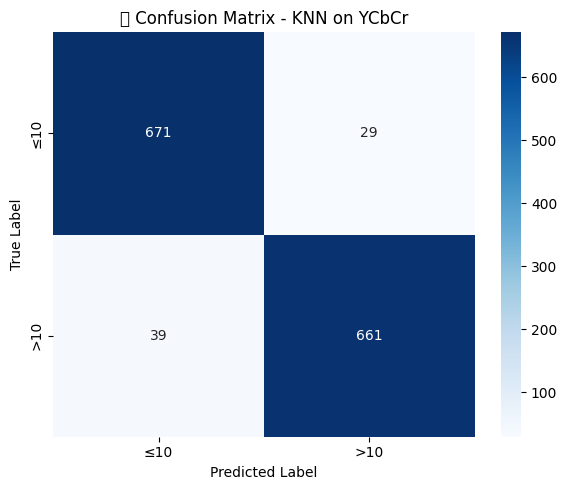

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load YCbCr-augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_ycbcr.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')
except FileNotFoundError:
    raise FileNotFoundError("❌ YCbCr-augmented files not found. Please generate X_aug_knn_ycbcr.npy and y_aug_knn.npy first.")

print(f"📦 Loaded YCbCr X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 YCbCr images into 1D vectors ===
X = X.reshape((X.shape[0], -1))
print(f"📐 Flattened YCbCr X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train KNN classifier ===
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)

print("🧠 Training KNN classifier...")
knn.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = knn.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + KNN on YCbCr: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# === Step 9: Plot Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - KNN on YCbCr")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


Random Forest

📦 Loaded YCbCr X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened YCbCr X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training Random Forest classifier on YCbCr...
✅ Training complete.

🎯 Accuracy after PCA + Random Forest on YCbCr: 0.9243
              precision    recall  f1-score   support

         ≤10       0.93      0.92      0.92       700
         >10       0.92      0.93      0.92       700

    accuracy                           0.92      1400
   macro avg       0.92      0.92      0.92      1400
weighted avg       0.92      0.92      0.92      1400


🧮 Confusion Matrix:
[[646  54]
 [ 52 648]]


/tmp/ipython-input-8-1669412371.py:91: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


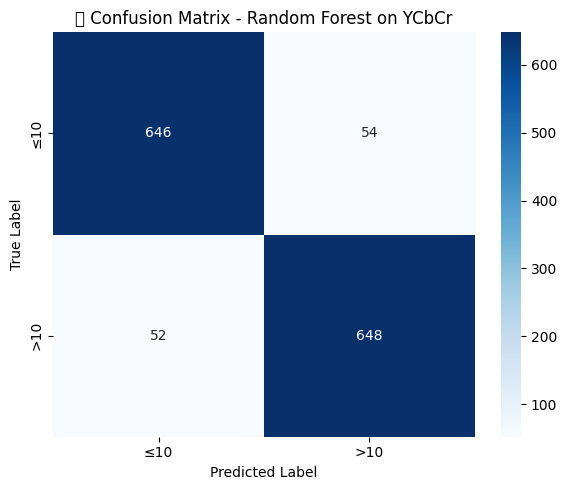

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier  # ✅ Replacing KNN with RF
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load YCbCr-augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_ycbcr.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')
except FileNotFoundError:
    raise FileNotFoundError("❌ YCbCr-augmented files not found. Please generate X_aug_knn_ycbcr.npy and y_aug_knn.npy first.")

print(f"📦 Loaded YCbCr X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 YCbCr images into 1D vectors ===
X = X.reshape((X.shape[0], -1))
print(f"📐 Flattened YCbCr X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train Random Forest classifier ===
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

print("🧠 Training Random Forest classifier on YCbCr...")
rf.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = rf.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + Random Forest on YCbCr: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# === Step 9: Plot Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - Random Forest on YCbCr")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


XGBOOST

📦 Loaded YCbCr X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened YCbCr X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training XGBoost classifier on YCbCr...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:20:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Training complete.

🎯 Accuracy after PCA + XGBoost on YCbCr: 0.9136
              precision    recall  f1-score   support

         ≤10       0.92      0.91      0.91       700
         >10       0.91      0.92      0.91       700

    accuracy                           0.91      1400
   macro avg       0.91      0.91      0.91      1400
weighted avg       0.91      0.91      0.91      1400


🧮 Confusion Matrix:
[[638  62]
 [ 59 641]]


/tmp/ipython-input-9-4016133874.py:94: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


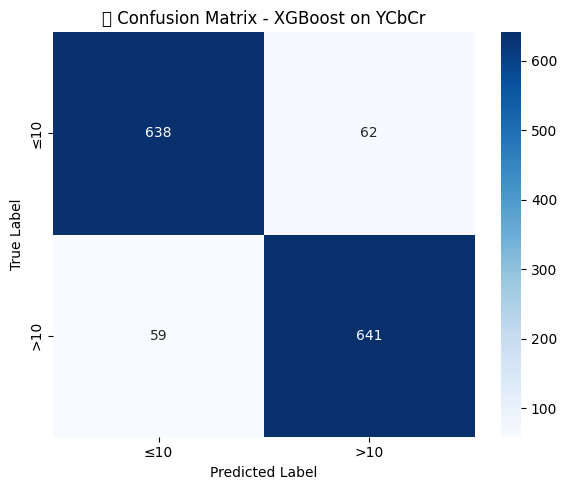

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier  # ✅ XGBoost
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load YCbCr-augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_ycbcr.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')
except FileNotFoundError:
    raise FileNotFoundError("❌ YCbCr-augmented files not found. Please generate X_aug_knn_ycbcr.npy and y_aug_knn.npy first.")

print(f"📦 Loaded YCbCr X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 YCbCr images into 1D vectors ===
X = X.reshape((X.shape[0], -1))
print(f"📐 Flattened YCbCr X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train XGBoost classifier ===
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

print("🧠 Training XGBoost classifier on YCbCr...")
xgb.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = xgb.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + XGBoost on YCbCr: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# === Step 9: Plot Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - XGBoost on YCbCr")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


SVM

📦 Loaded YCbCr X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened YCbCr X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training SVM classifier on YCbCr...
✅ Training complete.

🎯 Accuracy after PCA + SVM on YCbCr: 0.8214
              precision    recall  f1-score   support

         ≤10       0.83      0.82      0.82       700
         >10       0.82      0.83      0.82       700

    accuracy                           0.82      1400
   macro avg       0.82      0.82      0.82      1400
weighted avg       0.82      0.82      0.82      1400


🧮 Confusion Matrix:
[[571 129]
 [121 579]]


/tmp/ipython-input-10-4160265104.py:92: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


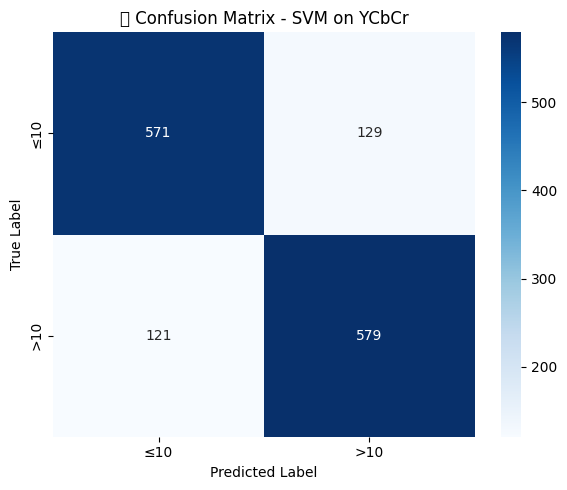

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC  # ✅ SVM classifier
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load YCbCr-augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_ycbcr.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')
except FileNotFoundError:
    raise FileNotFoundError("❌ YCbCr-augmented files not found. Please generate X_aug_knn_ycbcr.npy and y_aug_knn.npy first.")

print(f"📦 Loaded YCbCr X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 YCbCr images into 1D vectors ===
X = X.reshape((X.shape[0], -1))
print(f"📐 Flattened YCbCr X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train SVM classifier ===
svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

print("🧠 Training SVM classifier on YCbCr...")
svm.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = svm.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + SVM on YCbCr: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# === Step 9: Plot Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - SVM on YCbCr")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


***LAB***

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# -------- Configuration --------
input_folder = "/content/drive/MyDrive/Jaundice2/images"
corrected_output_folder = "/content/drive/MyDrive/Jaundice2/sample_corrected_output2"
roi_output_folder = "/content/drive/MyDrive/Jaundice2/sample_roi_output"
os.makedirs(corrected_output_folder, exist_ok=True)
os.makedirs(roi_output_folder, exist_ok=True)

# === CLAHE on L channel (from LAB)
def apply_lab_color_correction(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    corrected_lab = cv2.merge((l_clahe, a, b))
    corrected_bgr = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2BGR)
    corrected_rgb = cv2.cvtColor(corrected_bgr, cv2.COLOR_BGR2RGB)
    return corrected_rgb

# === Skin detection using LAB (ignores yellow card)
def extract_skin_roi(image_rgb):
    lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # --- Skin color range in LAB ---
    lower_skin = np.array([20, 130, 130], dtype=np.uint8)  # Conservative lower bound
    upper_skin = np.array([230, 170, 170], dtype=np.uint8)  # Conservative upper bound

    skin_mask = cv2.inRange(lab, lower_skin, upper_skin)

    # --- Morphological cleanup ---
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    coords = cv2.findNonZero(skin_mask)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        roi_size = 150
        cx, cy = x + w // 2, y + h // 2
        x1, y1 = max(0, cx - roi_size // 2), max(0, cy - roi_size // 2)
        x2, y2 = x1 + roi_size, y1 + roi_size
        return image_rgb[y1:y2, x1:x2]
    return None

# === Main processing loop ===
for filename in sorted(os.listdir(input_folder)):
    filepath = os.path.join(input_folder, filename)
    img_bgr = cv2.imread(filepath)
    if img_bgr is None:
        continue

    corrected_rgb = apply_lab_color_correction(img_bgr)
    roi_rgb = extract_skin_roi(corrected_rgb)

    if roi_rgb is not None:
        cv2.imwrite(os.path.join(corrected_output_folder, filename), cv2.cvtColor(corrected_rgb, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(roi_output_folder, filename), cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2BGR))


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd

# --- Configuration ---
roi_folder = "/content/drive/MyDrive/Jaundice2/sample_roi_output"
label_file = "/content/drive/MyDrive/Jaundice2/chd_jaundice_published_2.csv"
image_col = "image_idx"
target_col = "blood(mg/dL)"
save_x = "/content/drive/MyDrive/Jaundice2/X_rois_lab.npy"
save_y = "/content/drive/MyDrive/Jaundice2/y_labels.npy"

# --- Load Labels ---
df = pd.read_csv(label_file)

X = []
y = []

for fname in os.listdir(roi_folder):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        matched = df[df[image_col] == fname]
        if matched.empty:
            continue

        img_path = os.path.join(roi_folder, fname)
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            continue

        img_bgr = cv2.resize(img_bgr, (224, 224))

        # === Convert to LAB and normalize ===
        img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
        img_lab[..., 0] /= 255.0  # Normalize L
        img_lab[..., 1] /= 255.0  # Normalize A
        img_lab[..., 2] /= 255.0  # Normalize B

        X.append(img_lab)
        y.append(float(matched[target_col].values[0]))

X = np.array(X, dtype=np.float32)
y = np.array(y)

np.save(save_x, X)
np.save(save_y, y)

print(f"✅ Saved {X.shape[0]} LAB ROI samples as '{os.path.basename(save_x)}'")
print(f"✅ Saved corresponding labels as '{os.path.basename(save_y)}'")


✅ Saved 2235 LAB ROI samples as 'X_rois_lab.npy'
✅ Saved corresponding labels as 'y_labels.npy'


📊 Original counts: ≤10 = 876, >10 = 1359


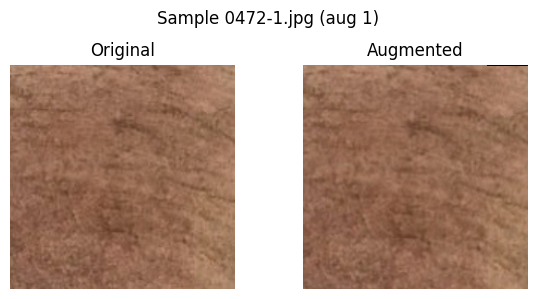

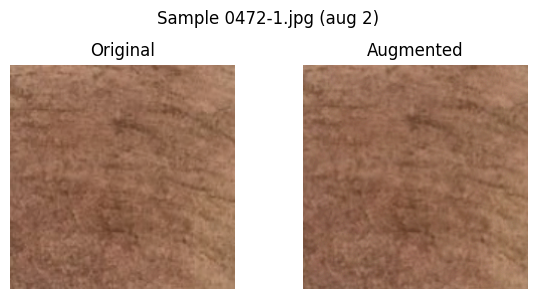

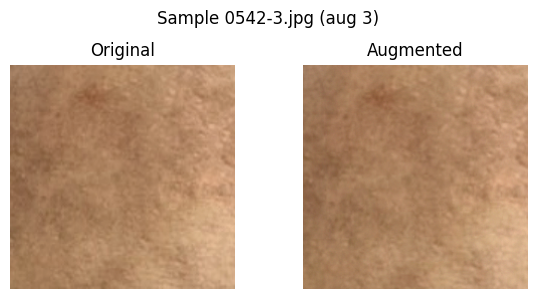

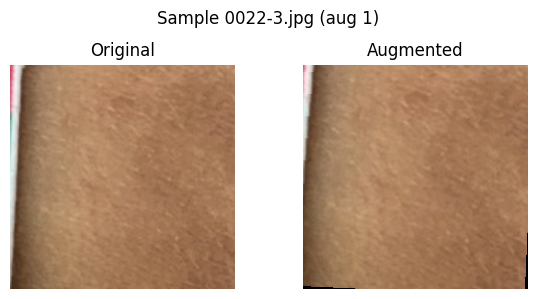

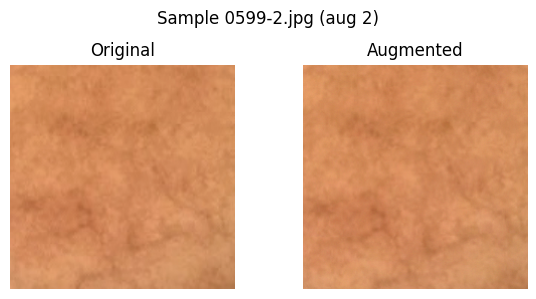

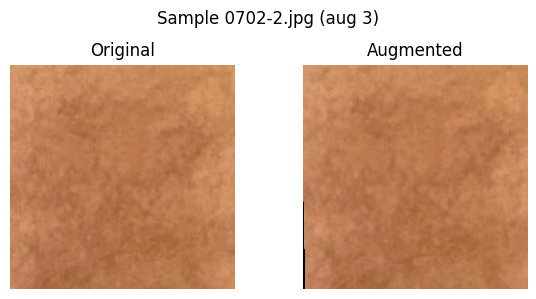

✅ Saved 7000 LAB samples to: /content/drive/MyDrive/Jaundice2/X_aug_knn_lab.npy
✅ Labels distribution: [3500 3500]


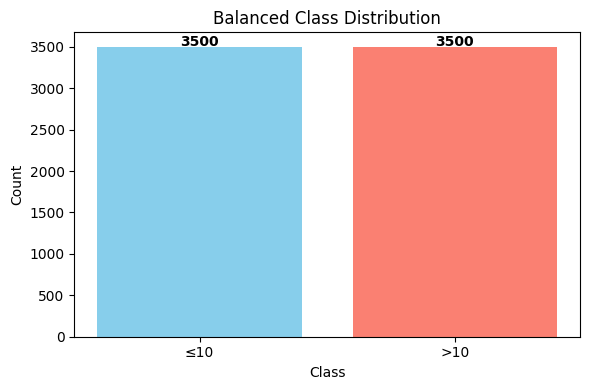

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from collections import defaultdict

# --- Configuration ---
roi_folder = "/content/drive/MyDrive/Jaundice2/sample_roi_output"
label_file = "/content/drive/MyDrive/Jaundice2/chd_jaundice_published_2.csv"
image_col = "image_idx"
target_col = "blood(mg/dL)"
threshold = 10.0
save_x = "/content/drive/MyDrive/Jaundice2/X_aug_knn_lab.npy"
save_y = "/content/drive/MyDrive/Jaundice2/y_aug_knn.npy"
target_count = 3500
show_examples = True

# --- Load labels ---
df = pd.read_csv(label_file)

# --- Gentle RGB-based Augmentation ---
class GentleAugment:
    def __init__(self):
        self.base_size = 232
        self.transform = transforms.Compose([
            transforms.Resize(self.base_size),
            transforms.RandomRotation(degrees=3, fill=0),
            transforms.RandomCrop(224, pad_if_needed=True),
        ])
        self.to_tensor = transforms.ToTensor()

    def __call__(self, img):
        img = self.transform(img)
        img = self.to_tensor(img)
        noise = torch.randn_like(img) * 0.005
        return torch.clamp(img + noise, 0, 1)

augment = GentleAugment()

# --- Visualizer for before/after (LAB -> RGB) ---
def show_before_after(original_lab, augmented_tensor, idx):
    lab_scaled = (original_lab * 255).astype(np.uint8)
    rgb_orig = cv2.cvtColor(lab_scaled, cv2.COLOR_LAB2RGB)
    aug_np = augmented_tensor.permute(1, 2, 0).numpy()
    aug_rgb = aug_np

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_orig)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(aug_rgb)
    plt.title("Augmented")
    plt.axis('off')
    plt.suptitle(f"Sample {idx}")
    plt.tight_layout()
    plt.show()

# --- Step 1: Organize by class ---
class_data = defaultdict(list)

for fname in os.listdir(roi_folder):
    if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    row = df[df[image_col] == fname]
    if row.empty:
        continue

    try:
        value = float(row[target_col].values[0])
    except:
        print(f"⚠ Invalid label for {fname}")
        continue

    label = 0 if value <= threshold else 1

    img_path = os.path.join(roi_folder, fname)
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠ Cannot read image: {fname}")
        continue

    img = cv2.resize(img, (224, 224))
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype(np.float32)
    img_lab /= 255.0  # Normalize L, A, B

    class_data[label].append((img_lab, fname))

# --- Step 2: Balance + Augment ---
X, y = [], []

print(f"📊 Original counts: ≤10 = {len(class_data[0])}, >10 = {len(class_data[1])}")

for label in [0, 1]:
    original = class_data[label]
    cur_count = len(original)

    if cur_count >= target_count:
        selected = random.sample(original, target_count)
        for img, _ in selected:
            X.append(img)
            y.append(label)
    else:
        for img, _ in original:
            X.append(img)
            y.append(label)

        needed = target_count - cur_count
        to_aug = random.choices(original, k=needed)
        for idx, (img, fname) in enumerate(to_aug):
            # LAB → RGB → PIL → Augment
            lab_scaled = (img * 255).astype(np.uint8)
            rgb = cv2.cvtColor(lab_scaled, cv2.COLOR_LAB2RGB)
            pil = Image.fromarray(rgb)
            aug_tensor = augment(pil)

            # RGB → LAB → Normalize
            aug_np = aug_tensor.permute(1, 2, 0).numpy()
            aug_lab = cv2.cvtColor((aug_np * 255).astype(np.uint8), cv2.COLOR_RGB2LAB).astype(np.float32)
            aug_lab /= 255.0

            X.append(aug_lab)
            y.append(label)

            if show_examples and idx < 3:
                show_before_after(img, aug_tensor, f"{fname} (aug {idx+1})")

# --- Step 3: Save arrays ---
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.uint8)

np.save(save_x, X)
np.save(save_y, y)

print(f"✅ Saved {X.shape[0]} LAB samples to: {save_x}")
print(f"✅ Labels distribution: {np.bincount(y)}")

# --- Step 4: Plot class balance ---
plt.figure(figsize=(6, 4))
plt.bar(['≤10', '>10'], np.bincount(y), color=['skyblue', 'salmon'])
plt.title("Balanced Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
for i, v in enumerate(np.bincount(y)):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from collections import Counter

# === Load the LAB-augmented dataset for KNN ===
X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_lab.npy')
y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')

print(f"🔍 Total samples in X (LAB): {X.shape}")
print(f"🔍 Total labels in y: {y.shape}")

# === Verify label range and count classes ===
unique_vals = np.unique(y)
if set(unique_vals) == {0, 1}:
    class_counts = Counter(y.astype(int))
else:
    raise ValueError(f"❌ Unexpected labels found in y: {unique_vals}. Expected only 0 and 1.")

print("\n📊 Final Class Distribution (Binary: ≤10 vs >10):")
print(f"  Class 0 (≤10): {class_counts[0]} samples")
print(f"  Class 1 (>10): {class_counts[1]} samples")


🔍 Total samples in X (LAB): (7000, 224, 224, 3)
🔍 Total labels in y: (7000,)

📊 Final Class Distribution (Binary: ≤10 vs >10):
  Class 0 (≤10): 3500 samples
  Class 1 (>10): 3500 samples


KNN

📦 Loaded LAB X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened LAB X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training KNN classifier...
✅ Training complete.

🎯 Accuracy after PCA + KNN on LAB: 0.9536
              precision    recall  f1-score   support

         ≤10       0.94      0.97      0.95       700
         >10       0.96      0.94      0.95       700

    accuracy                           0.95      1400
   macro avg       0.95      0.95      0.95      1400
weighted avg       0.95      0.95      0.95      1400


🧮 Confusion Matrix:
[[676  24]
 [ 41 659]]


/tmp/ipython-input-12-3369320701.py:86: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


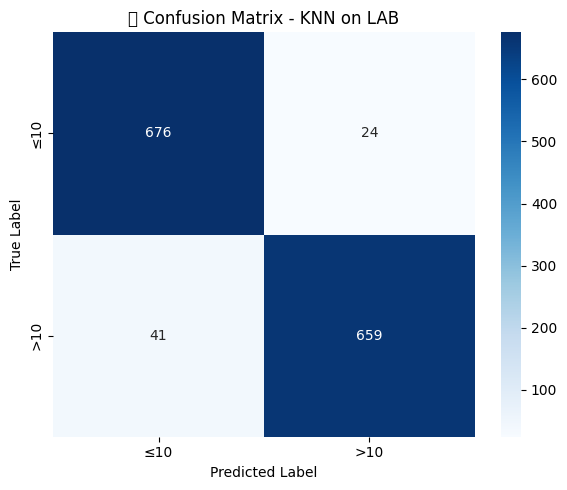

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load LAB-augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_lab.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')
except FileNotFoundError:
    raise FileNotFoundError("❌ LAB-augmented files not found. Please generate X_aug_knn_lab.npy and y_aug_knn.npy first.")

print(f"📦 Loaded LAB X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 LAB images into 1D vectors ===
X = X.reshape((X.shape[0], -1))
print(f"📐 Flattened LAB X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train KNN classifier ===
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1)

print("🧠 Training KNN classifier...")
knn.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = knn.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + KNN on LAB: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# === Step 9: Plot Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - KNN on LAB")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


RANDOM FOREST

📦 Loaded LAB X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened LAB X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training Random Forest classifier...
✅ Training complete.

🎯 Accuracy after PCA + Random Forest on LAB: 0.9293
              precision    recall  f1-score   support

         ≤10       0.93      0.93      0.93       700
         >10       0.93      0.93      0.93       700

    accuracy                           0.93      1400
   macro avg       0.93      0.93      0.93      1400
weighted avg       0.93      0.93      0.93      1400


🧮 Confusion Matrix:
[[653  47]
 [ 52 648]]


/tmp/ipython-input-13-3753631830.py:91: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


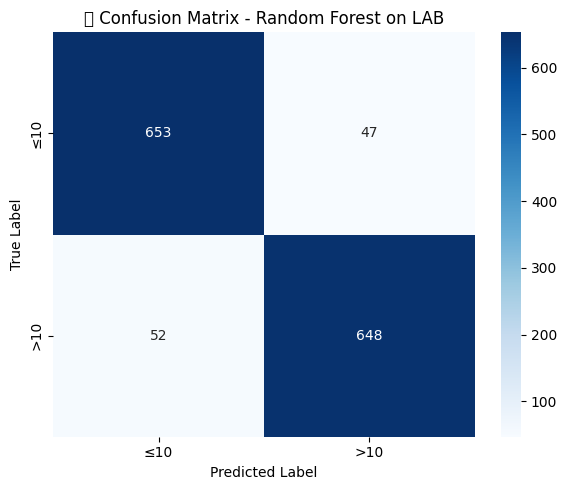

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load LAB-augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_lab.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')
except FileNotFoundError:
    raise FileNotFoundError("❌ LAB-augmented files not found. Please generate X_aug_knn_lab.npy and y_aug_knn.npy first.")

print(f"📦 Loaded LAB X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 LAB images into 1D vectors ===
X = X.reshape((X.shape[0], -1))
print(f"📐 Flattened LAB X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train Random Forest classifier ===
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

print("🧠 Training Random Forest classifier...")
rf.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = rf.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + Random Forest on LAB: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# === Step 9: Plot Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - Random Forest on LAB")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


SVM

📦 Loaded LAB X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened LAB X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training SVM classifier...
✅ Training complete.

🎯 Accuracy after PCA + SVM on LAB: 0.8357
              precision    recall  f1-score   support

         ≤10       0.85      0.81      0.83       700
         >10       0.82      0.86      0.84       700

    accuracy                           0.84      1400
   macro avg       0.84      0.84      0.84      1400
weighted avg       0.84      0.84      0.84      1400


🧮 Confusion Matrix:
[[568 132]
 [ 98 602]]


/tmp/ipython-input-14-3044492257.py:92: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


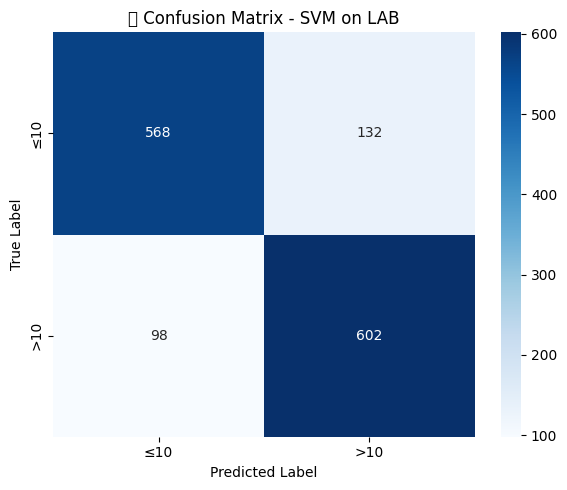

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load LAB-augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_lab.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')
except FileNotFoundError:
    raise FileNotFoundError("❌ LAB-augmented files not found. Please generate X_aug_knn_lab.npy and y_aug_knn.npy first.")

print(f"📦 Loaded LAB X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 LAB images into 1D vectors ===
X = X.reshape((X.shape[0], -1))
print(f"📐 Flattened LAB X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train SVM classifier ===
svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

print("🧠 Training SVM classifier...")
svm.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = svm.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + SVM on LAB: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# === Step 9: Plot Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - SVM on LAB")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


XGBOOST

📦 Loaded LAB X shape: (7000, 224, 224, 3), y shape: (7000,)
📐 Flattened LAB X shape: (7000, 150528)
✅ PCA output shape: (5600, 100)
🧠 Training XGBoost classifier...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:13:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Training complete.

🎯 Accuracy after PCA + XGBoost on LAB: 0.9129
              precision    recall  f1-score   support

         ≤10       0.90      0.92      0.91       700
         >10       0.92      0.90      0.91       700

    accuracy                           0.91      1400
   macro avg       0.91      0.91      0.91      1400
weighted avg       0.91      0.91      0.91      1400


🧮 Confusion Matrix:
[[647  53]
 [ 69 631]]


/tmp/ipython-input-15-874069269.py:94: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


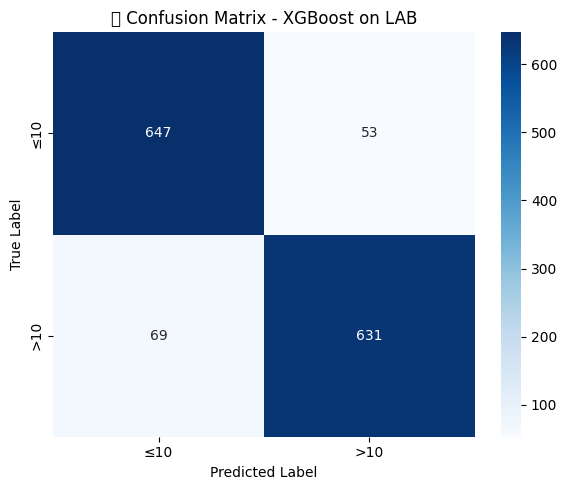

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load LAB-augmented image data ===
try:
    X = np.load('/content/drive/MyDrive/Jaundice2/X_aug_knn_lab.npy', mmap_mode='r')
    y = np.load('/content/drive/MyDrive/Jaundice2/y_aug_knn.npy')
except FileNotFoundError:
    raise FileNotFoundError("❌ LAB-augmented files not found. Please generate X_aug_knn_lab.npy and y_aug_knn.npy first.")

print(f"📦 Loaded LAB X shape: {X.shape}, y shape: {y.shape}")

# === Step 2: Flatten 224×224×3 LAB images into 1D vectors ===
X = X.reshape((X.shape[0], -1))
print(f"📐 Flattened LAB X shape: {X.shape}")

# === Step 3: Train/test split ===
train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

# === Step 4: Scale + PCA using batches ===
scaler = StandardScaler()
n_components = min(100, X.shape[1], len(train_idx))
pca = IncrementalPCA(n_components=n_components)

batch_size = 256
for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    scaler.partial_fit(batch)

for start in range(0, len(train_idx), batch_size):
    end = start + batch_size
    batch = X[train_idx[start:end]]
    batch_scaled = scaler.transform(batch)
    pca.partial_fit(batch_scaled)

# === Step 5: Transform in chunks ===
def transform_in_chunks(X, indices, scaler, pca, batch_size=256):
    chunks = []
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch = X[indices[start:end]]
        scaled = scaler.transform(batch)
        reduced = pca.transform(scaled)
        chunks.append(reduced)
    return np.vstack(chunks)

X_train_pca = transform_in_chunks(X, train_idx, scaler, pca, batch_size)
X_test_pca = transform_in_chunks(X, test_idx, scaler, pca, batch_size)
y_train = y[train_idx]
y_test = y[test_idx]

print(f"✅ PCA output shape: {X_train_pca.shape}")

# === Step 6: Train XGBoost classifier ===
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

print("🧠 Training XGBoost classifier...")
xgb.fit(X_train_pca, y_train)
print("✅ Training complete.")

# === Step 7: Evaluation ===
y_pred = xgb.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy after PCA + XGBoost on LAB: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=["≤10", ">10"]))

# === Step 8: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
print("\n🧮 Confusion Matrix:")
print(cm)

# === Step 9: Plot Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["≤10", ">10"], yticklabels=["≤10", ">10"])
plt.title("📊 Confusion Matrix - XGBoost on LAB")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# === Function to load, flatten, scale, and apply PCA ===
def preprocess_and_pca(X_path, y_path, batch_size=256, n_components=100):
    X = np.load(X_path, mmap_mode='r')
    y = np.load(y_path)
    X = X.reshape((X.shape[0], -1))
    train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    pca = IncrementalPCA(n_components=min(n_components, X.shape[1], len(train_idx)))

    for start in range(0, len(train_idx), batch_size):
        end = start + batch_size
        scaler.partial_fit(X[train_idx[start:end]])
    for start in range(0, len(train_idx), batch_size):
        end = start + batch_size
        batch_scaled = scaler.transform(X[train_idx[start:end]])
        pca.partial_fit(batch_scaled)

    def transform(indices):
        chunks = []
        for start in range(0, len(indices), batch_size):
            end = start + batch_size
            scaled = scaler.transform(X[indices[start:end]])
            reduced = pca.transform(scaled)
            chunks.append(reduced)
        return np.vstack(chunks)

    return transform(train_idx), transform(test_idx), y[train_idx], y[test_idx]

# === Function to evaluate a model ===
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    }

# === Paths ===
prefix = "/content/drive/MyDrive/Jaundice2/"
spaces = {
    "RGB": "X_aug_knn.npy",
    "HSV": "X_aug_knn_hsv.npy",
    "YCbCr": "X_aug_knn_ycbcr.npy",
    "LAB": "X_aug_knn_lab.npy"
}
y_path = prefix + "y_aug_knn.npy"

# === Models to evaluate ===
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5, weights='distance', n_jobs=-1),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42),
    "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
}

# === Final results storage ===
results = []

# === Iterate over all color spaces and models ===
for space_name, x_file in spaces.items():
    print(f"\n🔄 Processing {space_name}...")
    X_train, X_test, y_train, y_test = preprocess_and_pca(prefix + x_file, y_path)
    for model_name, model in models.items():
        print(f"   🧠 Evaluating {model_name}...")
        metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
        results.append({
            "Color Space": space_name,
            "Model": model_name,
            **metrics
        })

# === Convert results to DataFrame and display ===
df = pd.DataFrame(results)
print("\n📊 Final Comparison Table:")
print(df)

# === Optional: Save to CSV ===
# df.to_csv("model_comparison.csv", index=False)



🔄 Processing RGB...
   🧠 Evaluating KNN...
   🧠 Evaluating RandomForest...
   🧠 Evaluating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:25:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   🧠 Evaluating SVM...

🔄 Processing HSV...
   🧠 Evaluating KNN...
   🧠 Evaluating RandomForest...
   🧠 Evaluating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:34:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   🧠 Evaluating SVM...

🔄 Processing YCbCr...
   🧠 Evaluating KNN...
   🧠 Evaluating RandomForest...
   🧠 Evaluating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:43:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   🧠 Evaluating SVM...

🔄 Processing LAB...
   🧠 Evaluating KNN...
   🧠 Evaluating RandomForest...
   🧠 Evaluating XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:52:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   🧠 Evaluating SVM...

📊 Final Comparison Table:
   Color Space         Model  Accuracy  Precision    Recall        F1
0          RGB           KNN  0.941429   0.959821  0.921429  0.940233
1          RGB  RandomForest  0.919286   0.929722  0.907143  0.918294
2          RGB       XGBoost  0.922857   0.934018  0.910000  0.921852
3          RGB           SVM  0.843571   0.838256  0.851429  0.844791
4          HSV           KNN  0.944286   0.953353  0.934286  0.943723
5          HSV  RandomForest  0.922857   0.934018  0.910000  0.921852
6          HSV       XGBoost  0.910000   0.907670  0.912857  0.910256
7          HSV           SVM  0.819286   0.812587  0.830000  0.821201
8        YCbCr           KNN  0.951429   0.957971  0.944286  0.951079
9        YCbCr  RandomForest  0.924286   0.923077  0.925714  0.924394
10       YCbCr       XGBoost  0.913571   0.911807  0.915714  0.913756
11       YCbCr           SVM  0.821429   0.817797  0.827143  0.822443
12         LAB           KNN  0.953571  

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# === Color Space to File Map ===
color_spaces = {
    "RGB": "X_aug_knn.npy",
    "HSV": "X_aug_knn_hsv.npy",
    "YCbCr": "X_aug_knn_ycbcr.npy",
    "LAB": "X_aug_knn_lab.npy"
}
label_path = "/content/drive/MyDrive/Jaundice2/y_aug_knn.npy"
prefix = "/content/drive/MyDrive/Jaundice2/"

# === K values to try ===
k_values = [3, 4, 6]

# === Function to preprocess and reduce dimensionality ===
def preprocess_pca(X_path, y_path, n_components=100, batch_size=256):
    X = np.load(X_path, mmap_mode='r')
    y = np.load(y_path)
    X = X.reshape((X.shape[0], -1))  # Flatten image

    train_idx, test_idx = train_test_split(np.arange(len(y)), stratify=y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    pca = IncrementalPCA(n_components=min(n_components, X.shape[1], len(train_idx)))

    # Fit scaler
    for start in range(0, len(train_idx), batch_size):
        scaler.partial_fit(X[train_idx[start:start + batch_size]])

    # Fit PCA
    for start in range(0, len(train_idx), batch_size):
        batch = scaler.transform(X[train_idx[start:start + batch_size]])
        pca.partial_fit(batch)

    def transform(indices):
        transformed = []
        for start in range(0, len(indices), batch_size):
            batch = X[indices[start:start + batch_size]]
            scaled = scaler.transform(batch)
            reduced = pca.transform(scaled)
            transformed.append(reduced)
        return np.vstack(transformed)

    return transform(train_idx), transform(test_idx), y[train_idx], y[test_idx]

# === Collect results ===
results = []

for space, x_file in color_spaces.items():
    print(f"\n🔍 Processing {space} color space...")
    X_train_pca, X_test_pca, y_train, y_test = preprocess_pca(prefix + x_file, label_path)

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)
        knn.fit(X_train_pca, y_train)
        y_pred = knn.predict(X_test_pca)
        acc = accuracy_score(y_test, y_pred)

        results.append({
            "Color Space": space,
            "K": k,
            "Accuracy": round(acc, 4)
        })
        print(f"   ✅ K={k} | Accuracy: {acc:.4f}")

# === Create DataFrame for results ===
df = pd.DataFrame(results)
print("\n📊 Final Accuracy Comparison (KNN):")
print(df)

# === Optional: Save to CSV ===
# df.to_csv("knn_accuracy_comparison.csv", index=False)



🔍 Processing RGB color space...
   ✅ K=3 | Accuracy: 0.9507
   ✅ K=4 | Accuracy: 0.9400
   ✅ K=6 | Accuracy: 0.9343

🔍 Processing HSV color space...
   ✅ K=3 | Accuracy: 0.9579
   ✅ K=4 | Accuracy: 0.9536
   ✅ K=6 | Accuracy: 0.9314

🔍 Processing YCbCr color space...
   ✅ K=3 | Accuracy: 0.9557
   ✅ K=4 | Accuracy: 0.9550
   ✅ K=6 | Accuracy: 0.9543

🔍 Processing LAB color space...
   ✅ K=3 | Accuracy: 0.9621
   ✅ K=4 | Accuracy: 0.9579
   ✅ K=6 | Accuracy: 0.9500

📊 Final Accuracy Comparison (KNN):
   Color Space  K  Accuracy
0          RGB  3    0.9507
1          RGB  4    0.9400
2          RGB  6    0.9343
3          HSV  3    0.9579
4          HSV  4    0.9536
5          HSV  6    0.9314
6        YCbCr  3    0.9557
7        YCbCr  4    0.9550
8        YCbCr  6    0.9543
9          LAB  3    0.9621
10         LAB  4    0.9579
11         LAB  6    0.9500


RESNET

In [ ]:
pip install tensorflow scikit-learn xgboost seaborn pandas


In [ ]:
import numpy as np
import pandas as pd
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf

# ==== SETUP ====
IMG_SIZE = 224
BATCH_SIZE = 32
prefix = "/content/drive/MyDrive/Jaundice2/"
color_spaces = {
    "RGB": "X_aug_knn.npy",
    "HSV": "X_aug_knn_hsv.npy",
    "YCbCr": "X_aug_knn_ycbcr.npy",
    "LAB": "X_aug_knn_lab.npy"
}
label_path = prefix + "y_aug_knn.npy"

# ==== Load ResNet50 base model ====
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet_model = Model(inputs=resnet_base.input, outputs=GlobalAveragePooling2D()(resnet_base.output))

# ==== Define models ====
models = {
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42)
}

# ==== Feature Extraction in Batches ====
def extract_resnet_features(X, batch_size=32):
    features = []
    for i in range(0, len(X), batch_size):
        batch = X[i:i + batch_size].astype('float32')
        batch = tf.image.resize(batch, (IMG_SIZE, IMG_SIZE))
        batch = preprocess_input(batch)
        batch_features = resnet_model(batch, training=False).numpy()
        features.append(batch_features)
    return np.vstack(features)

# ==== Begin Evaluation ====
results = []
y = np.load(label_path).astype(np.int32)

for color, file_name in color_spaces.items():
    print(f"\n🔍 Processing {color} color space...")

    X = np.load(prefix + file_name).astype(np.float16)

    # Normalize if necessary
    if X.max() > 1.0:
        X /= 255.0

    # === Feature extraction ===
    features = extract_resnet_features(X, batch_size=BATCH_SIZE)
    del X
    gc.collect()

    # === Train-test split ===
    X_train, X_test, y_train, y_test = train_test_split(
        features, y, stratify=y, test_size=0.2, random_state=42
    )
    del features
    gc.collect()

    # === Standardize ===
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # === Train & Evaluate Models ===
    for model_name, model in models.items():
        print(f"   🔧 Training {model_name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        results.append({
            "Color Space": color,
            "Model": model_name,
            "Accuracy": round(acc, 4),
            "Precision (≤10)": round(report.get("≤10", {}).get("precision", 0), 4),
            "Recall (≤10)": round(report.get("≤10", {}).get("recall", 0), 4),
            "F1-score (≤10)": round(report.get("≤10", {}).get("f1-score", 0), 4),
            "Precision (>10)": round(report.get(">10", {}).get("precision", 0), 4),
            "Recall (>10)": round(report.get(">10", {}).get("recall", 0), 4),
            "F1-score (>10)": round(report.get(">10", {}).get("f1-score", 0), 4)
        })

    # Cleanup
    del X_train, X_test, y_train, y_test, scaler
    gc.collect()

# ==== Display as Table ====
df = pd.DataFrame(results)
print("\n📊 Evaluation Results:")
print(df)

# Optional: Save to CSV
# df.to_csv("/content/resnet_model_comparison.csv", index=False)



🔍 Processing RGB color space...
   🔧 Training KNN (k=5)...
   🔧 Training Random Forest...
   🔧 Training SVM...
   🔧 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:28:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 Processing HSV color space...
   🔧 Training KNN (k=5)...
   🔧 Training Random Forest...
   🔧 Training SVM...
   🔧 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:56:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 Processing YCbCr color space...
   🔧 Training KNN (k=5)...
   🔧 Training Random Forest...
   🔧 Training SVM...
   🔧 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:26:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 Processing LAB color space...
   🔧 Training KNN (k=5)...
   🔧 Training Random Forest...
   🔧 Training SVM...
   🔧 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:56:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Evaluation Results:
   Color Space          Model  Accuracy  Precision (≤10)  Recall (≤10)  \
0          RGB      KNN (k=5)    0.7386                0             0   
1          RGB  Random Forest    0.7429                0             0   
2          RGB            SVM    0.7050                0             0   
3          RGB        XGBoost    0.7821                0             0   
4          HSV      KNN (k=5)    0.7536                0             0   
5          HSV  Random Forest    0.7900                0             0   
6          HSV            SVM    0.7429                0             0   
7          HSV        XGBoost    0.8200                0             0   
8        YCbCr      KNN (k=5)    0.7486                0             0   
9        YCbCr  Random Forest    0.7221                0             0   
10       YCbCr            SVM    0.6943                0             0   
11       YCbCr        XGBoost    0.7571                0             0   
12         LAB 